In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

Loading BokehJS ...

### GPU
指定使用的 GPU 编号。  
`watch -n 1 nvidia-smi` 实时查看 GPU 的运行状态。 

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Data
通过`torchvision.datasets`下载`MNIST`数据。  
训练集：`train=True`  
测试集：`train=False`  
常用的还有`torchvision.datasets.ImageFolder()`，按文件夹取图片。  

`torchvision.transforms`可以对图片做处理。

In [3]:
train_dataset = dsets.MNIST(root='../dataset', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='../dataset', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

### Model
用线性网络构造出 AE，使得解码器的输出与输入尽量接近。

In [4]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return z, y

In [5]:
lrate = 0.01
epochs = 3

model = AE().cuda()
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lrate)
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

在训练过程中，每经过 300 个 batch 就检验 选中的 5 个图像的生成情况。

In [6]:
def list_img(i, img, title):
    img = img.reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('%s' % (title))
    
def generate_test(inputs, title=''):
    plt.figure(figsize=(15, 6))
    for i in range(len(inputs)):
        img = inputs[i].view(-1, 28*28).cuda()
        hidden, outputs = model(img)
        list_img(i, outputs.cpu().detach().numpy(), title)
    plt.show()

注意：每次反向传播的时候都需要将参数的梯度归零。  
`optim.step()`则在每个`Variable`的`grad`都被计算出来后，更新每个`Variable`的数值

在每次训练中都用`train_loader`中的一个`batch`作为训练数据。  
`Tensor.cuda()` 每个 `batch` 在实际使用之前，都先移入 `GPU` 后进行计算。  

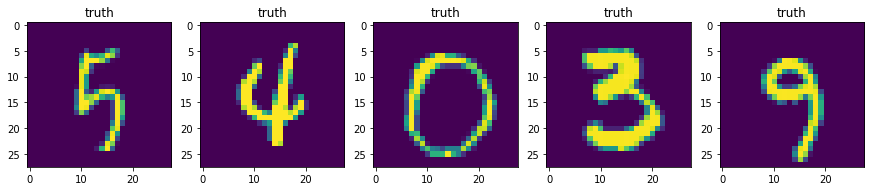

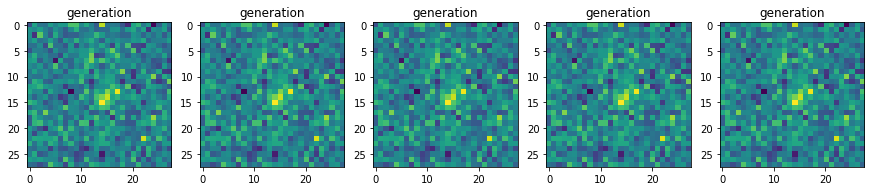

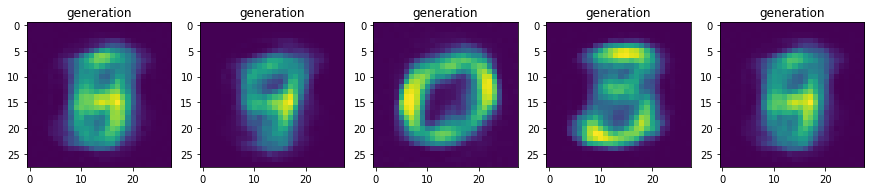

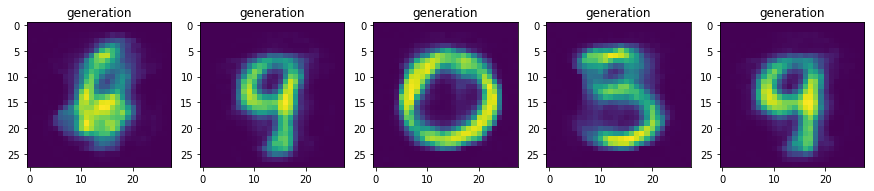

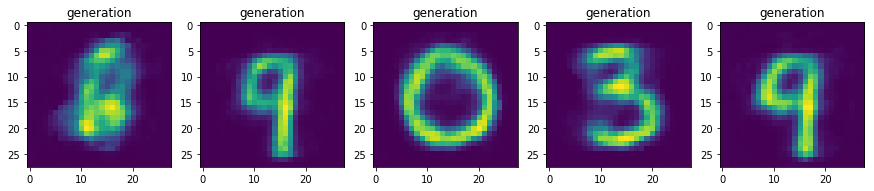

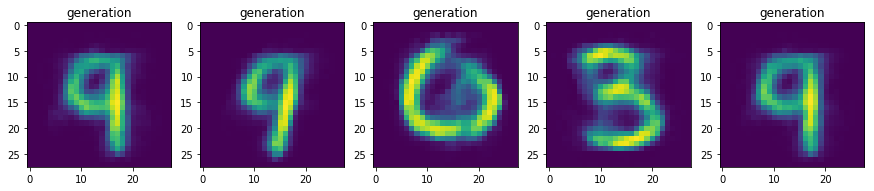

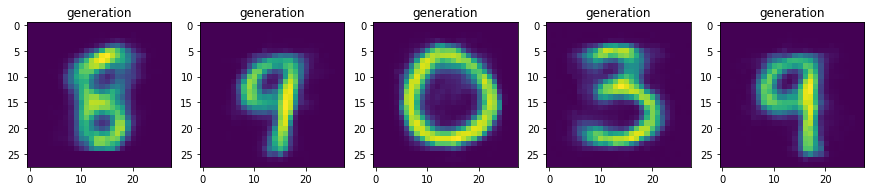

0.03937385231256485

In [7]:
result = []
test_inputs = []

plt.figure(figsize=(15, 6))
for i, (img, _) in enumerate(test_loader):
    if i > 4 : break
    test_inputs.append(img)
    list_img(i, img.numpy(), 'truth')
plt.show()

for e in range(epochs):
    for i, (inputs, _) in enumerate(train_loader):
        inputs = inputs.view(-1, 28*28).cuda()
        optim.zero_grad() 
        hidden, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optim.step()
        if i % 100 == 0:
            result.append(float(loss))
        if i % 300 == 0:
            generate_test(test_inputs, 'generation')
fig = figure()
fig.line(range(len(result)), result)
show(fig)
result[-1]

### Result
由上图可见图像的生成趋向于清晰。

查看编码层各个类别的分布情况。

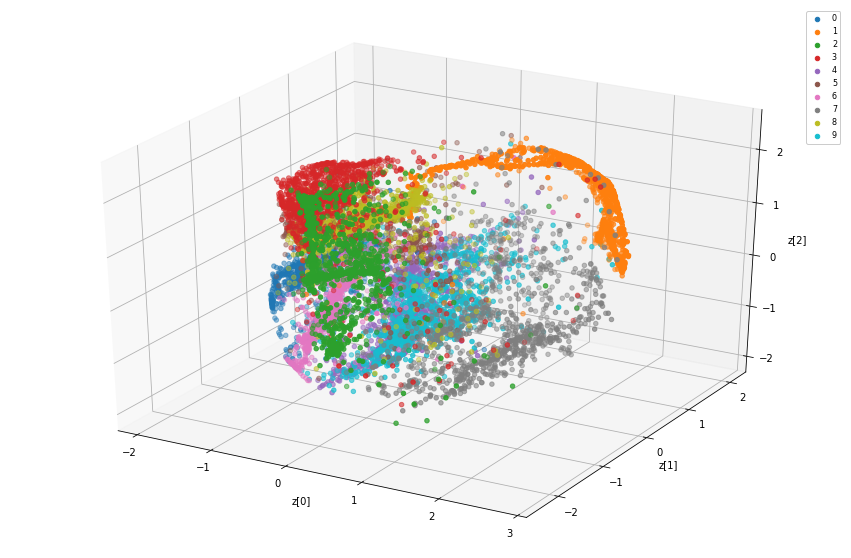

In [8]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

points = []
labels = []
for i, (inputs, lab) in enumerate(test_loader):
    inputs = inputs.view(-1, 28*28).cuda()
    hidden, _ = model(inputs)
    hidden = hidden.squeeze().cpu().detach().numpy()
    points.append(hidden)
    labels.append(lab.numpy())
    
labels = np.array(labels).squeeze()
points = np.array(points)

for digit in range(10):
    idx = np.argwhere(labels == digit).squeeze(1)
    pt = points[idx]
    ax.scatter(pt[:,0], pt[:,1], pt[:,2], marker='o', label=digit)

ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
ax.set_zlabel('z[2]')
ax.legend(loc=0,framealpha=1, fontsize=8)    
plt.show()

现在对编码层的其中一维做插值，查看生成图像的变化效果。

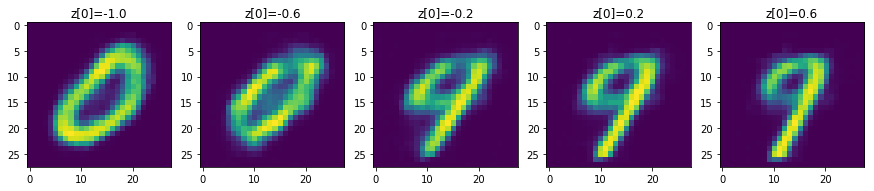

In [9]:
z = torch.randn(5, 3)
z = torch.tanh(z)
for i in range(5):
    z[i] = z[0]
    z[i][0] = 2.0/5*i - 1
z = z.cuda()
y = model.decoder(z)
plt.figure(figsize=(15, 6))
for i, img in enumerate(y):
    list_img(i, img.cpu().detach().numpy(), 'z[0]='+str(z[i][0].cpu().detach().numpy()))
plt.show()

In [10]:
z

tensor([[-1.0000,  0.7688, -0.3822],
        [-0.6000,  0.7688, -0.3822],
        [-0.2000,  0.7688, -0.3822],
        [ 0.2000,  0.7688, -0.3822],
        [ 0.6000,  0.7688, -0.3822]], device='cuda:3')

### Save Model

In [11]:
torch.save(model.state_dict(), 'autoencoder.pkl')